## Load Module

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as ly
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import shutil

## Parameters

In [2]:
# the lambda parameters to balance regression and gan phase. lambda mean the regresion influence on gan.
lambda_1 = 0
lambda_2 = 0

# Inputs:Global parameters 
batch_size = 10
img_dim = 1856
z_dim = 115
y_dim = 1

# Optimizer: whether use adam for parameters update , if flag is set false use tf.train.RMEPropOptimzer
is_adam = False
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
learning_rate_dis = 2e-4
# the upper bound and lower bound in critic
clamp_lower =-0.01
clamp_upper = 0.01


# Train : Prameters
max_iter_step = 30000
device = '/gpu:0'
data_format = 'NCHW'
channel = 1
# Updata Diters times for critic in one iter(unless i<25 or i %500==0, i is the iterstep)
c_iterv = 2
Diters = 5
Diters = int(((c_iterv+1)/c_iterv*Diters))

# Plot axis scale
scale = 0.08

# directory to store log ,include loss  and grad_norm of generator and critic
rgan_dir = './rgan_4'
log_dir = rgan_dir + '/log_rgan'
ckpt_dir = rgan_dir + '/ckpt_rgan'
spec_dir = rgan_dir + '/spec_rgan'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
else:
    shutil.rmtree(ckpt_dir)
    os.makedirs(ckpt_dir)
    
if not os.path.exists(spec_dir):
    os.makedirs(spec_dir)
else:
    shutil.rmtree(spec_dir)
    os.makedirs(spec_dir)

# write the hyperparameter to file
config_file = open(rgan_dir+'/config.txt','w')
config_file.write('lambda_1: %s\n lambda_2:%s' % (lambda_1,lambda_2))
config_file.close()

## Generator

In [3]:
def generator_conv(z):
    train = ly.fully_connected(z, 784*116, activation_fn = tf.nn.relu, normalizer_fn=None)
    train = tf.reshape(train,(-1,784,116,1))
    train = ly.conv2d_transpose(train, 392, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, 256, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, 128, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, channel , kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.tanh, padding='SAME',
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    return train

## Discriminator and Regressor

In [4]:
def lrelu(x,leak=0.2,name='lrelu'):
    with tf.variable_scope('lrelu'):
        f1 = 0.5*(1+leak)
        f2 = 0.5*(1-leak)
        return f1*x + f2*abs(x)

In [5]:
def critic_conv(x,reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        size = 64
        
        img = ly.conv2d(x,num_outputs=size,kernel_size=[3,1],stride=[2,1],padding='SAME',
                       activation_fn = lrelu,data_format=data_format,
                       weights_initializer = tf.random_normal_initializer(0,0.02))
        img = ly.conv2d(img,num_outputs= size*2,kernel_size=[3,1],stride=1,padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
        img = ly.conv2d(img,num_outputs= size*4,kernel_size=[3,1],stride=[2,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        img = ly.conv2d(img,num_outputs= size*8,kernel_size=[3,1],stride=1,padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
#         img = ly.conv2d(img,num_outputs= size*16,kernel_size=[3,1],stride=[2,1],padding='SAME',
#                         activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
#                         normalizer_params ={'fused':True,'data_format':data_format},
#                         weights_initializer = tf.random_normal_initializer(0,0.02))
#         img = ly.conv2d(img,num_outputs= size*32,kernel_size=[3,1],stride=1,padding='SAME',
#                         activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
#                         normalizer_params ={'fused':True,'data_format':data_format},
#                         weights_initializer = tf.random_normal_initializer(0,0.02))
        img = tf.reshape(img,[batch_size,-1])
        
        disc = ly.fully_connected(img,1,activation_fn=None)
        regr = ly.fully_connected(img,1,activation_fn=tf.nn.sigmoid)
    
    return disc,regr

## Build Graph & Loss Function

In [6]:
def build_graph(is_test=False):
    ##########################  Inputs ######################################
    # real data 
    real_data = tf.placeholder(dtype = tf.float32,shape=[batch_size,channel,img_dim,1])
    real_label = tf.placeholder(dtype = tf.float32,shape =[batch_size,y_dim])
    
    # Noise
    z_reg = tf.placeholder(dtype = tf.float32,shape =[batch_size,y_dim])
    z_rand = tf.placeholder(dtype =tf.float32,shape =[batch_size,z_dim])
    z = tf.concat([z_reg,z_rand],axis=1)
    #########################  End Inputs #####################################
    
    ##########################  Graph   ######################################
    generator = generator_conv
    discriminator = critic_conv
    
    with tf.variable_scope('generator'):
        gen = generator(z)
    
    disc_real,regr_real = discriminator(real_data)
    disc_fake,regr_fake = discriminator(gen, reuse=True)
    
    # Wasserstein distance
    d_loss = tf.reduce_mean(disc_fake - disc_real)
    g_loss = tf.reduce_mean( - disc_fake)
    g_loss_summ = tf.summary.scalar('wasserstein_loss_g' , g_loss)
    d_loss_summ = tf.summary.scalar('wasserstein_loss_d' , -d_loss)
    
    # Regression loss
    r_loss_f = tf.nn.l2_loss(regr_fake-z_reg)
    r_loss_r = tf.nn.l2_loss(regr_real-real_label)
    r_loss = (r_loss_f + r_loss_r)/2
    r_loss_f_summ = tf.summary.scalar('regression_f_loss',r_loss_f)
    r_loss_r_summ = tf.summary.scalar('regression_r_loss',r_loss_r)
    r_loss_r_summ = tf.summary.scalar('regression_loss',r_loss)
    
    # Loss of Discriminator and Generator, Discriminator train on True and False data
    loss_gen = (1-lambda_1)* g_loss+ lambda_1 * r_loss_f
    loss_disc = (1-lambda_2)* d_loss+ lambda_2 * r_loss
    loss_gen_summ = tf.summary.scalar('generator_loss',r_loss_f)
    loss_disc_summ = tf.summary.scalar('discriminator_loss',r_loss_r)
    
    ########################### End Graph   ######################################
    if is_test:
        return gen,regr_real,z_reg,z_rand,real_data
    
    ##################### Optimization ########################################
    # Variable Collection
    theta_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='generator')
    theta_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='discriminator')
    
    # Optimizers
    counter_g = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_g = optimize(loss = loss_gen,learning_rate = learning_rate_gen,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    variables=theta_g, global_step=counter_g,summaries=['gradient_norm','gradients'])
    
    counter_d = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_d = optimize(loss =loss_disc,learning_rate = learning_rate_dis,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    variables=theta_d, global_step=counter_d,summaries=['gradient_norm','gradients'])
    
    # Clip weights
    clipped_var_d = [tf.assign(var,tf.clip_by_value(var,clamp_lower,clamp_upper)) for var in theta_d]
    with tf.control_dependencies([opt_d]):
        opt_d = tf.tuple(clipped_var_d)
    ################################# End Optimization ################################################
    return opt_d, opt_g ,real_data,real_label,z_reg,z_rand,loss_disc,loss_gen,r_loss,gen

##  Optimizer

In [7]:
def optimize(loss,learning_rate, optimizer,variables,global_step,summaries):
    optim = optimizer(learning_rate=learning_rate)
    
    # Caculate gradients
    gradients = optim.compute_gradients(loss,var_list = variables)
    
    # Add summary
    if summaries is None:
        summaries = ['loss','learning_rate']
    if 'gradient_norm'  in summaries:
        tf.summary.scalar('global_norm/gradient_norm',tf.global_norm(list(zip(*gradients))[0]))
        
    if 'loss' in summaries:
        tf.summary.scalar('loss',loss)
    
    for gradient,variable in gradients:
        if isinstance(gradient,tf.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        
        if grad_values is not None:
            var_name = variable.name.replace(':','_')
            if 'gradients' in summaries:
                tf.summary.histogram('gradients/%s'%var_name, grad_values)
            
            if 'gradient_norm' in summaries:
                tf.summary.scalar('gradient_norm/%s'%var_name,tf.global_norm([grad_values]))
    return optim.apply_gradients(gradients,global_step=global_step)
        

## Plot

In [8]:
def save_spectrum(gen, i,is_show=False):
    # control the spect limitation and intv determine the the distance of spectrums
    intv = 0
    # extend along y axis to visulize the difference between spetrum
    if is_show:
        extd = np.matlib.repmat(np.arange(0,batch_size),img_dim,1) 
        extd = extd * scale*intv
    else:
        extd = np.zeros((img_dim, batch_size))
    # convert data to ideal format    
    spec = gen.reshape(batch_size,img_dim)*(xmax-xmin)+ xmin
    spec = spec.transpose() + extd
    
    # plot the spectrum with ylimit legend and other thing
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(spec.shape[0]),spec ,'-*')
    if is_show:
        if intv ==0:
            plt.ylim([0,scale])
        else:
            plt.ylim([0,scale*batch_size*intv])
    else:
        plt.ylim([0,scale])
    
    plt.legend([np.array_str(var) for var in np.arange(batch_size)])
    
    if is_show:
        return plt.show()
    # savefig
    plt.savefig(spec_dir+'/'+str(i).zfill(4)+'.png')
    plt.close('all')

## Training Phase

Load dataset

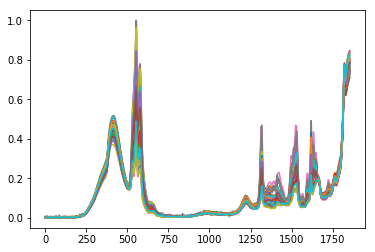

In [9]:
# from database load the data and label,clip the length network required
spect = scio.loadmat('ndata.mat')
x,y = spect['orgin'].transpose(),spect['result'][:,1]
if x.shape[1]>img_dim:
    x = x[:,:img_dim]
# pre_processing by minmaxmap
xmin, xmax, ymin, ymax = x.min(),x.max(), y.min(),y.max()
x,y = (x - xmin)/( xmax - xmin ),(y - ymin)/( ymax - ymin )

# reshape the data to the format that look like image
x= x.reshape(-1,1,img_dim,1)
x_show = np.reshape(x,[-1,img_dim])
plt.plot(x_show.transpose())
plt.show()

In [10]:
def main():
    with tf.device(device):
        opt_d, opt_g ,real_data,real_label,z_reg,z_rand ,loss_dis,loss_gen ,r_loss,gen = build_graph()
    
    merged_all = tf.summary.merge_all()
    saver = tf.train.Saver()
    
    # config for Session and allow soft_placement
    config = tf.ConfigProto(allow_soft_placement = True,log_device_placement=True)
    config.gpu_options.allow_growth =True
    config.gpu_options.per_process_gpu_memory_fraction=0.9
    
    def next_feed_dict(iter,shuffled=True):
        # True data
        if shuffled:
            idx = np.random.randint(x.shape[0],size=(batch_size,))
            
        train_img,train_label = x[idx],y[idx].reshape(batch_size,1)
        
        #False data
        batch_z_rand = np.random.normal(0,1,[batch_size,z_dim]).astype(np.float32)
        # Gererate random labels as conditions , [0,1] gausson distribution
        if iter %2 ==0:
            y_generated = np.random.uniform(0,1,[batch_size,y_dim])
        else:
            y_generated = np.matlib.repmat(np.random.uniform(0,1),batch_size,y_dim)
            
        feed_dict = {real_data:train_img, real_label:train_label, z_rand:batch_z_rand, z_reg:y_generated}
        
        return feed_dict
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter(log_dir,sess.graph)
        
        # training loop
        for i in range(max_iter_step+1):
            if i % 100 ==0:
                print(i)
            if i < 25 or i % 500 ==0:
                diters = 10
            else:
                diters = Diters
                
            #  Train Discriminator
            for j in range(diters):
                feed_dict = next_feed_dict(i)
                if i % 100  ==0 and j ==0:
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.NO_TRACE)
                    run_metadata = tf.RunMetadata()

                    _,loss_of_dis,loss_of_reg,merged = sess.run([opt_d,loss_dis,r_loss,merged_all],feed_dict =feed_dict,
                                                          run_metadata=run_metadata,options =run_options)
                    print('the loss of discriminator and regression is %0.3f and %0.3f respectively'%(loss_of_dis,loss_of_reg))

                    summary_writer.add_summary(merged,i)
                    summary_writer.add_run_metadata(run_metadata,'discriminator_metedata{}'.format(i),i)
                else:
                    sess.run(opt_d,feed_dict =feed_dict,options =run_options)
            
            # Train Generator
            feed_dict = next_feed_dict(i)
            if i %100 ==0:
                _,loss_of_reg,spec,merged = sess.run([opt_g,loss_gen,gen,merged_all],feed_dict =feed_dict,
                                                 run_metadata=run_metadata,options = run_options)
                
                save_spectrum(spec,i)
                print('the loss of generator is %0.3f'%loss_of_reg)
                summary_writer.add_summary(merged, i)
                summary_writer.add_run_metadata(run_metadata,'generator_metadata{}'.format(i),i)
            else:
                sess.run(opt_g,feed_dict=feed_dict)
                
            # Save Model
            if i % 1000 ==0:
                saver.save(sess, os.path.join(ckpt_dir,'model_checkpoint'),global_step=i)
                

##  Testing Phase

In [11]:
def test(ckpt_dir=ckpt_dir):
    
    with tf.Session(config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
        # build graph
        with tf.device(device):
            gen,regr_real,z_reg,z_rand,real_data = build_graph(is_test=True)
        
        
        # use saver to reload the parametes
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(ckpt_dir))
        
        
        ###########################################  Experiment : Generator #################
        # Gererate random labels as conditions , [0,1] gausson distribution
        batch_z_rand = np.random.normal(0,1,[batch_size,z_dim]).astype(np.float32)
        y_generated = np.linspace(0,1,batch_size).reshape(batch_size,1)
        
        test_gen = sess.run(gen,feed_dict={z_rand:batch_z_rand,z_reg:y_generated}) 
        
        # Visualize the result
        save_spectrum(test_gen,_,is_show=True)
        
        ###########################################  Experiment : Regression #################        
        idx = 30
        test_img,test_label = x[idx:],y[idx:]
        
        pred_label = sess.run(regr_real,feed_dict ={real_data:test_img})
        
        print('the r2 score is %0.3f'%r2_score(pred_label,test_label))
        # plot Correlation coefficient diagram
        plt.plot(np.arange(len(test_label)),test_label,'r-',
                 np.arange(len(test_label)),pred_label,'b--')
        plt.show()
            

In [12]:
if __name__ =='__main__':
    tf.reset_default_graph()
    main()

0
the loss of discriminator and regression is -0.164 and 0.392 respectively
the loss of generator is 0.407
100
the loss of discriminator and regression is -1424.519 and 0.824 respectively
the loss of generator is 130.180
200
the loss of discriminator and regression is -1481.482 and 0.656 respectively
the loss of generator is 412.029
300
the loss of discriminator and regression is -1410.752 and 0.418 respectively
the loss of generator is 274.031
400
the loss of discriminator and regression is -1435.166 and 0.715 respectively
the loss of generator is 235.776
500
the loss of discriminator and regression is -1506.589 and 0.694 respectively
the loss of generator is 384.489
600
the loss of discriminator and regression is -1417.858 and 0.718 respectively
the loss of generator is 519.644
700
the loss of discriminator and regression is -1273.182 and 0.777 respectively
the loss of generator is 343.862
800
the loss of discriminator and regression is -1426.317 and 0.767 respectively
the loss of ge

INFO:tensorflow:Restoring parameters from ./rgan_4/ckpt_rgan\model_checkpoint-30000


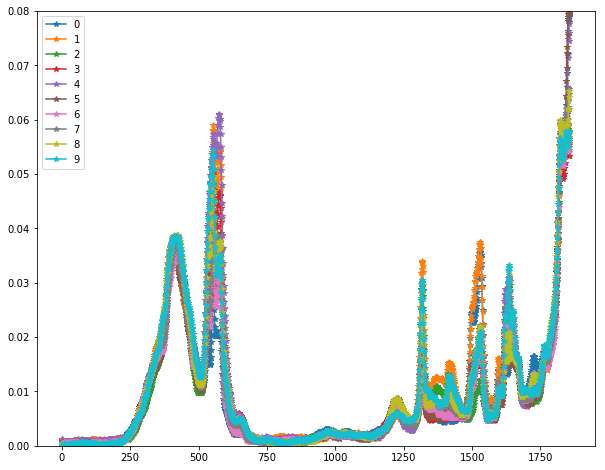

the r2 score is -7.635


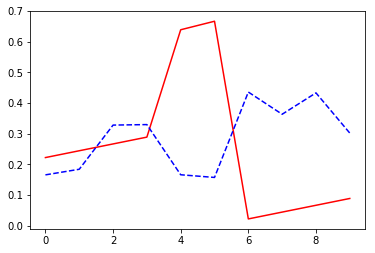

In [13]:
tf.reset_default_graph()
test(ckpt_dir)